# Image enhancement with Image Super-Resolution using U-Net

This project demonstrates how to build and train a U-Net model for **image super-resolution**.  
The objective is to take a low-resolution image (64×64) and upscale it into a high-resolution version (256×256).

The **U-Net architecture** is particularly effective for this task due to its encoder–decoder structure with skip connections.  
- The **encoder** captures global context and feature representations.  
- The **decoder** reconstructs fine details, while skip connections help preserve spatial information.  

By combining both local and global features, the U-Net enables generation of sharper and more detailed high-resolution images, making it well-suited for tasks like **super-resolution** and **object detection preprocessing**.

### 1. Setup and Imports

For training U-Net model, including Keras for model definition, OpenCV for image processing and Matplotlib for visualization.

In [33]:
import os
import cv2 as cv
import numpy as np
import requests, os
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from tensorflow.keras.models import load_model
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout

### 2. U-Net Model Definition

This cell defines the U-Net model architecture for image super-resolution. The `unet_64to256` function creates a U-Net model that takes a 64x64x3 image as input and outputs a 256x256x3 image. It includes an encoder, a bottleneck, and a decoder with skip connections.

In [34]:
def unet_64to256(input_shape=(64, 64, 3), n_classes=3, final_activation='sigmoid', dropout_rate=0.05):
    inputs = Input(shape=input_shape, name='img')

    # Encoder
    c1 = Conv2D(16, (3,3), padding='same')(inputs)
    c1 = BatchNormalization()(c1); c1 = Activation('relu')(c1)
    c1 = Conv2D(16, (3,3), padding='same')(c1)
    c1 = BatchNormalization()(c1); c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2,2))(c1); p1 = Dropout(dropout_rate)(p1)   # 64 -> 32

    c2 = Conv2D(32, (3,3), padding='same')(p1)
    c2 = BatchNormalization()(c2); c2 = Activation('relu')(c2)
    c2 = Conv2D(32, (3,3), padding='same')(c2)
    c2 = BatchNormalization()(c2); c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2,2))(c2); p2 = Dropout(dropout_rate)(p2)   # 32 -> 16

    c3 = Conv2D(64, (3,3), padding='same')(p2)
    c3 = BatchNormalization()(c3); c3 = Activation('relu')(c3)
    c3 = Conv2D(64, (3,3), padding='same')(c3)
    c3 = BatchNormalization()(c3); c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2,2))(c3); p3 = Dropout(dropout_rate)(p3)   # 16 -> 8

    c4 = Conv2D(128, (3,3), padding='same')(p3)
    c4 = BatchNormalization()(c4); c4 = Activation('relu')(c4)
    c4 = Conv2D(128, (3,3), padding='same')(c4)
    c4 = BatchNormalization()(c4); c4 = Activation('relu')(c4)
    p4 = MaxPooling2D((2,2))(c4); p4 = Dropout(dropout_rate)(p4)   # 8 -> 4

    # Bottleneck (4x4)
    c5 = Conv2D(256, (3,3), padding='same')(p4)
    c5 = BatchNormalization()(c5); c5 = Activation('relu')(c5)
    c5 = Conv2D(256, (3,3), padding='same')(c5)
    c5 = BatchNormalization()(c5); c5 = Activation('relu')(c5)

    # Decoder
    u6 = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(c5)  # 4 -> 8
    u6 = concatenate([u6, c4]); u6 = Dropout(dropout_rate)(u6)
    u6 = Conv2D(128, (3,3), padding='same')(u6)
    u6 = BatchNormalization()(u6); u6 = Activation('relu')(u6)
    u6 = Conv2D(128, (3,3), padding='same')(u6)
    u6 = BatchNormalization()(u6); u6 = Activation('relu')(u6)

    u7 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(u6)    # 8 -> 16
    u7 = concatenate([u7, c3]); u7 = Dropout(dropout_rate)(u7)
    u7 = Conv2D(64, (3,3), padding='same')(u7)
    u7 = BatchNormalization()(u7); u7 = Activation('relu')(u7)
    u7 = Conv2D(64, (3,3), padding='same')(u7)
    u7 = BatchNormalization()(u7); u7 = Activation('relu')(u7)

    u8 = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(u7)    # 16 -> 32
    u8 = concatenate([u8, c2]); u8 = Dropout(dropout_rate)(u8)
    u8 = Conv2D(32, (3,3), padding='same')(u8)
    u8 = BatchNormalization()(u8); u8 = Activation('relu')(u8)
    u8 = Conv2D(32, (3,3), padding='same')(u8)
    u8 = BatchNormalization()(u8); u8 = Activation('relu')(u8)

    u9 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u8)    # 32 -> 64
    u9 = concatenate([u9, c1]); u9 = Dropout(dropout_rate)(u9)
    u9 = Conv2D(16, (3,3), padding='same')(u9)
    u9 = BatchNormalization()(u9); u9 = Activation('relu')(u9)
    u9 = Conv2D(16, (3,3), padding='same')(u9)
    u9 = BatchNormalization()(u9); u9 = Activation('relu')(u9)

    # Upsample to 128
    u10 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u9)   # 64 -> 128
    u10 = Dropout(dropout_rate)(u10)
    u10 = Conv2D(16, (3,3), padding='same')(u10)
    u10 = BatchNormalization()(u10); u10 = Activation('relu')(u10)

    # NEW extra upsample to 256
    u11 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u10)   # 128 -> 256
    u11 = Dropout(dropout_rate)(u11)
    u11 = Conv2D(16, (3,3), padding='same')(u11)
    u11 = BatchNormalization()(u11); u11 = Activation('relu')(u11)

    outputs = Conv2D(n_classes, (1,1), activation=final_activation, name='mask')(u11)
    
    return Model(inputs=inputs, outputs=outputs, name='UNet_64to256')

### 3. Model Initialization and Compilation

This cell initializes the U-Net model with the specified input shape and number of classes. It then compiles the model using the Adam optimizer and mean absolute error (MAE) as the loss function. The input and output shapes are printed to verify the model architecture.

In [35]:
model = unet_64to256(input_shape=(64,64,3), n_classes=3, final_activation='sigmoid')

print('Input shape:', model.input_shape)   # (None, 64, 64, 3)
print('Output shape:', model.output_shape) # (None, 256, 256, 3)

model.compile(optimizer=Adam(1e-4), loss='mae')

Input shape: (None, 64, 64, 3)
Output shape: (None, 256, 256, 3)


### 4. Data Generator

A **data pipeline** for training the UNet super-resolution model using TensorFlow's `tf.data` API.

1. **Image Loading and Preprocessing**

   * Each image file is read from disk and decoded into a 3-channel RGB image.
   * Two versions of the image are created:

     * **High-resolution (256×256)** → the target output for training.
     * **Low-resolution (64×64)** → the input to the model.
   * Pixel values are normalized to the `[0,1]` range for neural network training.

2. **Parallel Processing**

   * `AUTOTUNE` allows TensorFlow to automatically determine the optimal number of parallel calls when mapping the parsing function.

3. **Dataset Pipeline**

   * `list_files` collects all image paths from the dataset directory.
   * `map` applies the parsing function to each file.
   * `shuffle` randomizes the dataset order to improve training generalization.
   * `batch` groups images into batches of 32 for efficient training.
   * `prefetch` overlaps data preparation and model execution for better performance.

**Overall:** This block converts raw image files into an efficient, batched, and normalized dataset of paired low- and high-resolution images, ready for training a super-resolution model.

In [36]:
base_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'

def parse_image(filename):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img_hr = tf.image.resize(img, [256, 256]) / 255.0  # High-res target
    img_lr = tf.image.resize(img, [64, 64]) / 255.0    # Low-res input
    return img_lr, img_hr

# Use experimental.AUTOTUNE for older TF versions
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset = (tf.data.Dataset.list_files(os.path.join(base_dir, "*.jpg"))
           .map(parse_image, num_parallel_calls=AUTOTUNE)
           .shuffle(buffer_size=1000)
           .batch(32)
           .prefetch(AUTOTUNE))

### 5. Pre Pipeline Processing:

This code block sets up **visualization and checkpointing** during training using a custom callback.

1. **Directories Setup**

   * `checkpoint_dir` → stores the latest model weights.
   * `sample_dir` → stores sample predictions per epoch for monitoring model performance visually.
   * Both directories are created if they don’t already exist.

2. **Visualization Function (`show_and_save_samples`)**

   * Randomly selects `n` images from the dataset.
   * For each image, it generates:

     * **Original image**
     * **Ground-truth high-res (256×256)**
     * **Upscaled low-res input (64×64 → 256×256)**
     * **Model prediction**
   * Plots all four side by side and saves the figure for the current epoch.

3. **Callback (`on_epoch_end`)**

   * Runs **after each training epoch**.
   * Calls `show_and_save_samples` to generate and save visual examples.
   * Saves the **latest model** in `.h5` format to `checkpoint_dir`.
   * Using `.h5` ensures the checkpoint is easy to load later.

4. **Integration with `model.fit`**

   * `show_cb` is a `LambdaCallback` passed to `model.fit`.
   * Ensures checkpointing and sample visualization happen automatically **every epoch**.

**Overall:** This block provides continuous monitoring of the model’s learning progress while safely saving only the latest checkpoint to avoid clutter.

In [41]:
# --- Directories ---
base_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'
checkpoint_dir = './checkpoints'
sample_dir = './epoch_samples'
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(sample_dir, exist_ok=True)

# --- List of all images for visualization ---
imgs = os.listdir(base_dir)

# --- Function to show and save sample predictions ---
def show_and_save_samples(model, imgs, base_dir, epoch, n=5, save_dir=sample_dir):
    os.makedirs(save_dir, exist_ok=True)
    chosen = np.random.choice(imgs, n, replace=False)
    fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))
    if n == 1: axes = np.expand_dims(axes, 0)

    for i, fname in enumerate(chosen):
        path = os.path.join(base_dir, fname)
        rgb = cv.cvtColor(cv.imread(path), cv.COLOR_BGR2RGB)

        # Ground truth 256x256
        gt256 = cv.resize(rgb, (256,256)).astype('float32') / 255.0
        # Low-res input 64x64
        img64 = cv.resize(rgb, (64,64)).astype('float32') / 255.0
        # Model prediction
        pred = model.predict(np.expand_dims(img64, 0), verbose=0)[0]
        # Upscaled low-res for comparison
        lowup = cv.resize((img64*255).astype(np.uint8), (256,256))

        for ax, im, title in zip(
            axes[i],
            [rgb, gt256, lowup, pred],
            ['Original', 'GT 256x256', 'Low-Res Upscaled', 'Prediction']
        ):
            ax.imshow(im)
            ax.set_title(title)
            ax.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, f"epoch_{epoch+1:02d}.png"))
    plt.close(fig)

# --- Callback: save sample + checkpoint (only latest) ---
def on_epoch_end(epoch, logs):
    # Save sample images
    show_and_save_samples(model, imgs, base_dir, epoch)
    
    # Save only latest model (.h5 format for easier loading)
    latest_path = os.path.join(checkpoint_dir, 'latest_model.h5')
    model.save(latest_path, overwrite=True)
    print(f"✅ Saved latest model to {latest_path}")

# --- LambdaCallback for model.fit ---
show_cb = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

### 5. Model Training

This cell trains the U-Net model for a small number of epochs (10) using the `dataprep` function. 

In [38]:
# Train the model

results = model.fit(
    dataset,  # your tf.data pipeline
    epochs=10,
    callbacks=[show_cb],
    verbose=1
)

Epoch 1/10
6332/6332 [==============================] - 509s 80ms/step - loss: 0.0444
Epoch 2/10
6332/6332 [==============================] - 508s 80ms/step - loss: 0.0312
Epoch 3/10
6332/6332 [==============================] - 510s 81ms/step - loss: 0.0294
Epoch 4/10
6332/6332 [==============================] - 508s 80ms/step - loss: 0.0274
Epoch 5/10
6332/6332 [==============================] - 508s 80ms/step - loss: 0.0251
Epoch 6/10
6332/6332 [==============================] - 510s 81ms/step - loss: 0.0240
Epoch 7/10
6332/6332 [==============================] - 506s 80ms/step - loss: 0.0234
Epoch 8/10
6332/6332 [==============================] - 507s 80ms/step - loss: 0.0230
Epoch 9/10
6332/6332 [==============================] - 508s 80ms/step - loss: 0.0226
Epoch 10/10
6332/6332 [==============================] - 514s 81ms/step - loss: 0.0223


### 7. Test with a real image:

✅ Loaded model from ./checkpoints/latest_model.h5


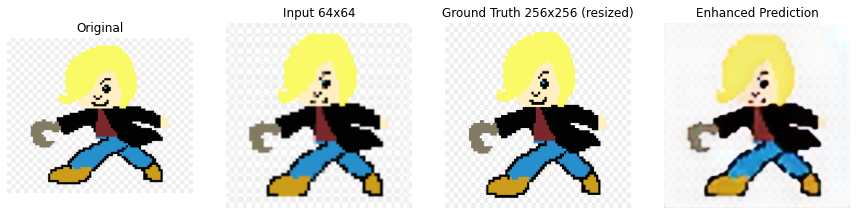

In [40]:
# --- Load Trained Model (use .h5 to avoid folder issue) ---
model_path = "./checkpoints/latest_model.h5"  # save/load in .h5 format
if not os.path.exists(model_path):
    raise FileNotFoundError(f"❌ Model not found at {model_path}. Train and save first.")
model = load_model(model_path)
print(f"✅ Loaded model from {model_path}")

# --- Download image from GitHub raw link ---
url = "https://raw.githubusercontent.com/kush-agra-soni/Image_enhancement_model_UNET/refs/heads/main/sample.png"
user_img = "/kaggle/working/sample.png"

if not os.path.exists(user_img):
    r = requests.get(url, stream=True)
    with open(user_img, "wb") as f:
        f.write(r.content)
    print(f"✅ Downloaded image to {user_img}")

# --- Function to Enhance Image ---
def enhance_image(img_path, model, input_size=(64,64), output_size=(256,256)):
    # Load image
    bgr = cv.imread(img_path)
    if bgr is None:
        raise ValueError(f"❌ Could not read image at {img_path}")
    rgb = cv.cvtColor(bgr, cv.COLOR_BGR2RGB)

    # Preprocess input
    low_res = cv.resize(rgb, input_size).astype("float32") / 255.0
    inp = np.expand_dims(low_res, axis=0)

    # Predict high-res
    pred = model.predict(inp, verbose=0)[0]

    # Ground-truth resized (for comparison)
    gt = cv.resize(rgb, output_size)

    return rgb, low_res, gt, pred

# --- Run enhancement ---
orig, low_res, gt, pred = enhance_image(user_img, model)

# --- Plot Results ---
plt.figure(figsize=(12,6))
titles = ["Original", "Input 64x64", "Ground Truth 256x256 (resized)", "Enhanced Prediction"]
images = [orig,
          (low_res*255).astype(np.uint8),
          gt,
          np.clip(pred*255, 0, 255).astype(np.uint8)]

for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(1,4,i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")

plt.tight_layout()
plt.show()

### 8. Project Summary

This notebook successfully implemented and trained a U-Net–based model for **image super-resolution**. The model was trained on the CelebA dataset, taking **64×64 images as input** and generating **256×256 images** as output.

The training process showed a consistent decrease in the **mean absolute error (MAE) loss** across epochs, demonstrating that the model is learning to reconstruct fine details at higher resolutions. The visualizations saved after each epoch provide a clear picture of how the predictions evolve and improve during training.

Further improvements could include:

* Experimenting with advanced loss functions (e.g., perceptual loss, SSIM, or adversarial loss).
* Leveraging a **validation set** to better track generalization performance.
* Using a larger and more diverse dataset for better robustness.
* Exploring **GAN-based super-resolution** approaches (e.g., SRGAN, ESRGAN) for sharper outputs.
* Hyperparameter tuning (learning rate, optimizer, augmentation strategies) to maximize performance.
* Deploying the trained model as a lightweight API or inference pipeline for real-world applications.

---
